### Testing the original model with some holonomic movement

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt

import central_complex
import cx_rate
import trials
import analysis
import plotter

save_figs=True

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Generate outbound routes

Use the `trials` module to generate an outbound route. Internally this is using the `bee_simulator` and `central_complex` modules to simulate the physics and electrophysiology.

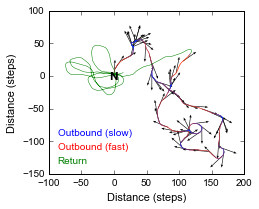

In [2]:
route_file = 'route.npz'
load_route = False
save_route = False

T_outbound = 1500
T_inbound = 1500
noise = 0.1

if load_route:
    h, v, _ = trials.load_route(filename=route_file)
else:
    h, v = trials.generate_route(T=T_outbound, vary_speed=True)
    
cx = cx_rate.CXRatePontin(noise=noise)

h, v, log, cpu4_snapshot = trials.run_trial(logging=True,
                                            T_outbound=T_outbound,
                                            T_inbound=T_inbound,
                                            noise=noise,
                                            cx=cx,
                                            route=(h[:T_outbound], v[:T_outbound]))

if save_route and not load_route:
    print "saving..."
    trials.save_route(h=h, v=v, cx_log=log, filename=route_file)

fig, ax = plotter.plot_route(h, v, T_outbound=T_outbound, T_inbound=T_inbound,
                   plot_speed=True, plot_heading=True, quiver_color='black')
        
if save_figs:
    plotter.save_plot(fig, 'example_route')

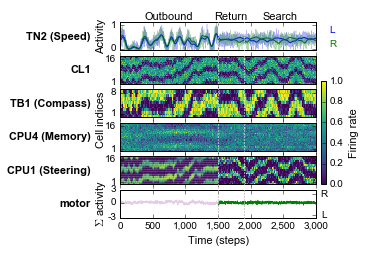

In [3]:
start=500
length=2000

trimmed_log = trials.CXLogger(T_outbound=T_outbound-start,
                              T_inbound=length-T_outbound+start,
                              cx=cx_rate.CXRate())
trimmed_log.tl2 = log.tl2[:,start:start+length]
trimmed_log.cl1 = log.cl1[:,start:start+length]
trimmed_log.tb1 = log.tb1[:,start:start+length]
trimmed_log.tn1 = log.tn1[:,start:start+length]
trimmed_log.tn2 = log.tn2[:,start:start+length]
trimmed_log.memory = log.memory[:,start:start+length]
trimmed_log.cpu4 = log.cpu4[:,start:start+length]
trimmed_log.cpu1 = log.cpu1[:,start:start+length]
trimmed_log.motor = log.motor[start:start+length]

fig, ax = plotter.plot_traces(
        log, include=['TN2', 'CL1', 'TB1', 'CPU4', 'CPU1', 'motor'])
        #trimmed_log, include=['TN1', 'TN2', 'CL1', 'TB1', 'CPU4', 'CPU1', 'motor'], t_start=start)
if save_figs:
    plotter.save_plot(fig, 'example_traces')

The default acceration, drag and rotation params ensure that drift rarely exceeds pi/4 and speed remains under 1.0.

This is necessary for the partially holonomic model of path integration.

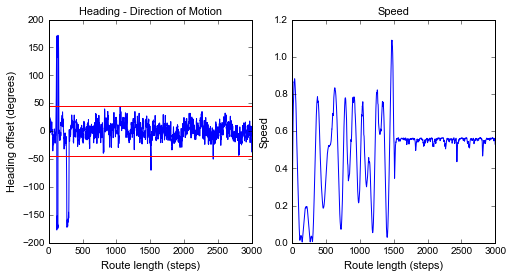

In [4]:
fig, ax = plt.subplots(1,2, figsize =(8,4))
plotter.plot_angle_of_motion(h, v, ax[0])
plotter.plot_speed(v, ax[1])
if save_figs:
    plotter.save_plot(fig, 'example_motion_properties')

### Collect bulk data

In [5]:
def analyse(N, param_dict):
    """Iterates through param dictionary, running batches of trials according to the param dictionary"""
    min_dists =[]
    min_dist_stds = []
    disk_leaving_angles = []
    
    cx_decoder = cx_rate.CXRatePontin()  # Default rate model for decoding
    
    for i in range(param_dict['n']):
        kwargs = {}
        for k, v in param_dict.iteritems():
            if k != 'n' and v[i] != None:
                kwargs[k] = v[i]
                        
        H, V, cpu4_snapshot = trials.generate_dataset(N=N, **kwargs)
        
        if 'T_outbound' in kwargs:
            T_outbound = kwargs['T_outbound']
        else:
            T_outbound = 1500

        # Closest position to nest within return part.
        min_d, min_d_sigma = analysis.compute_closest_to_nest(V, T_outbound)
        
        # Angular distance between angle to nest and location where agent leaves radius around turning point 
        # (To mimic some behavioural experiments)
        disk_leaving_angle = analysis.compute_disk_leaving_angle(V, T_outbound)

        min_dists.append(min_d)
        min_dist_stds.append(min_d_sigma)
        disk_leaving_angles.append(disk_leaving_angle)
    
    return min_dists, min_dist_stds, disk_leaving_angles

Run N trials at different path distances AND four different noise values, also using completely random homing. Analyse each set of trials for average error and minimum distance

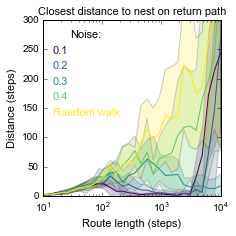

In [6]:
N = 10 #100
N_dists = 30
distances = np.round(10 ** np.linspace(1, 4, N_dists)).astype('int')
noise_vals = [0.1, 0.2, 0.3, 0.4]
noise_legend_vals = noise_vals + ['Random']

param_dicts = [{'n':N_dists, 'noise': [noise]*N_dists, 'T_outbound': distances, 'T_inbound': distances} for noise in noise_vals]
param_dicts.append({'n':N_dists, 'T_outbound': distances, 'T_inbound': distances, 'random_homing':[True]*N_dists})

for param_dict in param_dicts:
    param_dict['cx_class'] = [cx_rate.CXRatePontin] * param_dict['n']

errors_l = []
error_stds_l = []
min_dists_l = []
min_dist_stds_l = []
    
for param_dict in param_dicts:
    min_dists, min_dist_stds, _ = analyse(N, param_dict)
    min_dists_l.append(min_dists)
    min_dist_stds_l.append(min_dist_stds)

fig, ax = plotter.plot_distance_v_noise(min_dists_l,
                                        min_dist_stds_l,
                                        distances,
                                        noise_legend_vals,
                                        title='Closest distance to nest on return path')

if save_figs:
    plotter.save_plot(fig, 'noise_v_distance_memory')

Run N trials at four different noise values, also using completely random homing. Analyse each set of trials for angular offset from nest

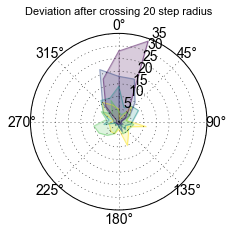

In [7]:
N = 100 #1000
noise = [0.1, 0.2, 0.3, 0.4, 0.1]
random_homing = [None, None, None, None, True]
noise_legend_vals = [0.1, 0.2, 0.3, 0.4, 'Random']

param_dict = {'n':len(noise),
              'noise': noise,
              'random_homing': random_homing,
              'cx_class': [cx_rate.CXRatePontin] * len(noise)}
  
# Analyse
_, _, disk_leaving_angles = analyse(N, param_dict)

# Plot results
fig, ax = plotter.plot_angular_distances(
        noise_legend_vals, disk_leaving_angles,# log_scale=True,
        title='Deviation after crossing 20 step radius')
if save_figs:
    plotter.save_plot(fig, 'angle_offset_20_step_radius')

Run N trials across a wide range of parameter ranges, aiming to break the model

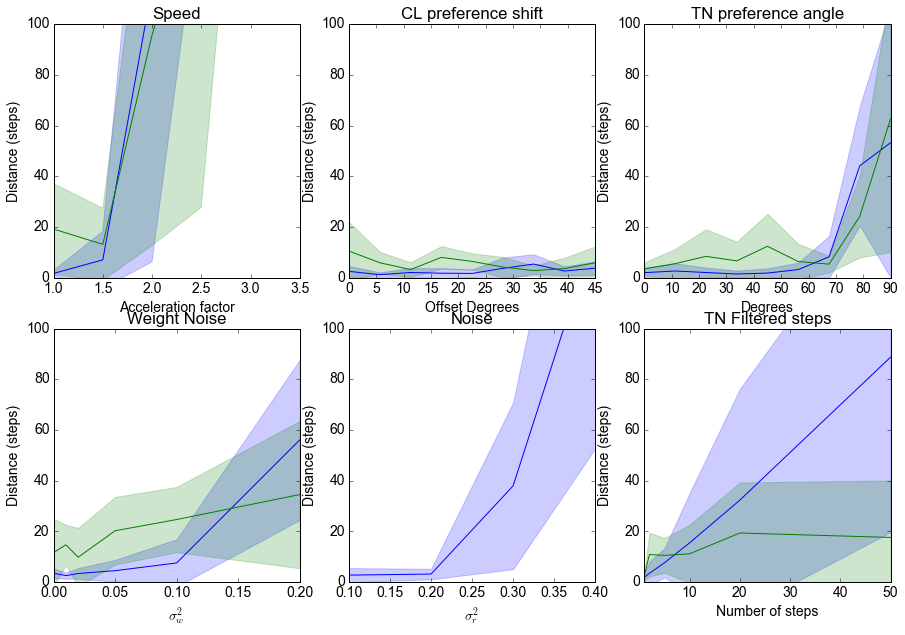

In [9]:
N = 10 #1000
T_outbound = 1500
T_inbound = 1500
T = T_outbound + T_inbound

distances = np.array([1000, 2000, 5000, 10000, 20000, 50000])
acc_factors = np.array([1, 1.5, 2, 2.5, 3, 3.5]) 
acc_out = acc_factors * trials.default_acc
bump_shift = np.linspace(0, np.pi/4, 9)
tn_prefs = np.linspace(0.0, np.pi/2, 9)
weight_noise = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2]
noise = [0.1, 0.2, 0.3, 0.4]
filtered_steps = [1, 2, 5, 10, 20, 50]

#param_dicts = [{'n':len(distances), 'T_outbound': distances, 'T_inbound': distances},
param_dicts = [{'n':len(acc_out), 'acc_out': acc_out, 'T_inbound': (acc_factors * T_inbound).astype('int')},
               {'n':len(bump_shift), 'bump_shift': bump_shift},
               {'n':len(tn_prefs), 'tn_prefs': tn_prefs},
               {'n':len(weight_noise), 'weight_noise': weight_noise},
               {'n':len(noise), 'noise': noise},
               {'n':len(filtered_steps), 'filtered_steps': filtered_steps}
]

for param_dict in param_dicts:
    param_dict['cx_class'] = [cx_rate.CXRatePontin] * param_dict['n']
#noise_levels = [0.4]

x_ticks = [acc_factors, np.rad2deg(bump_shift), np.rad2deg(tn_prefs), weight_noise, noise, filtered_steps]
x_labels = ['Acceleration factor', 'Offset Degrees', 'Degrees', '$\sigma_w^2$', '$\sigma_r^2$', 'Number of steps']
titles = ['Speed', 'CL preference shift','TN preference angle', 'Weight Noise', 'Noise', 'TN Filtered steps']

fig, ax = plt.subplots(2,3, figsize=(15,10))

for i in range(2):
    for j, param_dict in enumerate(param_dicts):
        color = 'blue'
        if i % 2 == 1:
            if j == 4: # Don't do this to the noise plot
                continue
            param_dict['noise'] = np.zeros(param_dict['n'])
            color= 'green'

        min_dists, min_dist_stds, _ = analyse(N, param_dict)

        ax[j/3][j%3].plot(x_ticks[j], min_dists, color=color)
        ax[j/3][j%3].set_title(titles[j])
        ax[j/3][j%3].set_xlabel(x_labels[j])
        ax[j/3][j%3].set_ylabel('Distance (steps)')
        ax[j/3][j%3].set_xlim([x_ticks[j][0], x_ticks[j][-1]])
        ax[j/3][j%3].set_ylim([0,100])
        ax[j/3][j%3].fill_between(x_ticks[j],
                                  [m+s for m, s in zip(min_dists, min_dist_stds)],
                                  [m-s for m, s in zip(min_dists, min_dist_stds)],
                                  alpha=0.2,
                                  color=color);

if save_figs:
    plotter.save_plot(fig, 'breaking_the_model_pos_estimate')

Calculate straightness of path home

Tortoisity for mean homebound path up to 1 route length of steps is 1.18604222952


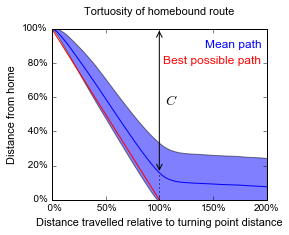

In [10]:
N=100
T_outbound=1500
T_inbound=1500
noise = 0.1

H, V, _ = trials.generate_dataset(T_outbound, T_inbound, noise, N, cx_class=cx_rate.CXRatePontin)
cum_min_dist = analysis.compute_path_straightness(V, T_outbound)

fig, ax = plotter.plot_route_straightness(cum_min_dist)
if save_figs:
    plotter.save_plot(fig, 'path_straightness')
    
tort = analysis.compute_tortuosity(cum_min_dist)
print "Tortoisity for mean homebound path up to 1 route length of steps is", tort

We can calculate the tortuosity using the most basic formula: $$\tau = L / C$$